In [22]:
%load_ext autoreload
%autoreload 2
from readers.base import NeuralynxReader
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, decimate
import numpy as np
import pandas as pd
import stumpy
from numba import cuda
import matplotlib.colors as mcolors
from detectors.motives import MotifFinder
%matplotlib tk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
rootdir = '/media/sil2/Data/Lizard/lorenz_data/2019-11-17_17-43-33'
rd = NeuralynxReader(rootdir, channel=32)

In [24]:
%%time
mf = MotifFinder(rd, decimate_q=15, lowpass=150, filter_order=3)
mf.search(t_start=3*3600, t_stop=3.5*3600)

Finish calculating matrix profile with window of 2 seconds in 35.1 minutes.
Finish calculating matrix profile with window of 0.4 seconds in 5.0 minutes.
CPU times: user 25min 34s, sys: 14min 45s, total: 40min 19s
Wall time: 40min 19s


In [26]:
fig, axes = plt.subplots(1,2)
for i, m in enumerate(mf.motives):
    axes[i].plot(m)

In [16]:
colors = list(mcolors.TABLEAU_COLORS.values())

def plot_found_motives(v_, t_, w, mi, motives=None):
    n_motives, n_examples = mi.shape
    fig = plt.figure(figsize=(25, 5))
    ax = fig.gca()
    ax.margins(0)
    ax.plot(t_, v_, color='k')
    motives = motives or range(n_motives)
    for i in motives:
        for j in range(n_examples):
            idx = mi[i, j]
            ax.plot(t_[idx:idx+w], v_[idx:idx+w], color=colors[i])

def plot_motives(v_, w, mi, cols=6):
    n_motives, n_examples = mi.shape
    cols = n_examples if n_examples < cols else cols
    fig, axes = plt.subplots(n_motives, cols, figsize=(25, 3*n_motives))
    if n_motives == 1:
        axes = axes.reshape(*axes.shape, 1)
    for i in range(n_motives):
        for j in range(cols):
            idx = mi[i, j]
            axes[i, j].plot(v_[idx:idx+w], color=colors[i])
    fig.tight_layout()

def check_motives(mi, w):
    M = np.zeros((mi.shape[0], mi.shape[0]))
    for row1 in range(mi.shape[0]):
        for row2 in range(mi.shape[0]): #np.arange(mi.shape[0]-1, row1, -1):
            for i in mi[row1, :]:
                if i == -1:
                    break
                if any(i <= k <= (i+w) for k in mi[row2, :]) or any(i <= k+w <= (i+w) for k in mi[row2, :]):
                    M[row1, row2] += 1
        l = np.where(mi[row1,:] == -1)[0]
        M[row1, :] /= l[0] if len(l) > 0 else mi.shape[1]
    return M

In [7]:
%%time
v, t = rd.read(i_start=int((3*3600)*rd.fs), i_stop=int((3.5*3600)*rd.fs), lowpass=150, filter_order=3)
decimate_q = 15
# t_start, t_end = 10, 230  # seconds
# v, t = v[int(t_start*rd.fs):int(t_end*rd.fs)], t[int(t_start*rd.fs):int(t_end*rd.fs)]
if decimate_q:
    v, t = decimate(v, decimate_q), decimate(t, decimate_q)
plt.figure(figsize=(25, 5))
plt.plot(t, v)
plt.margins(0)

CPU times: user 2.29 s, sys: 512 ms, total: 2.8 s
Wall time: 3.74 s


In [8]:
%%time

all_gpu_devices = [device.id for device in cuda.list_devices()]  # Get a list of all available GPU devices
window = int(rd.fs * 2 / decimate_q)
mps = stumpy.gpu_stump(v, m=window, device_id=all_gpu_devices)
motif_distance = np.round(mps[:, 0].min(), 1)
motifs_idx = np.argsort(mps[:, 0])[:2]
print(f"The motif pair matrix profile value is {motif_distance}")

The motif pair matrix profile value is 9.4
CPU times: user 21min 6s, sys: 14min 9s, total: 35min 16s
Wall time: 35min 16s


In [20]:
%%time

motif_distances, motif_indices = stumpy.motifs(v, mps[:, 0], max_motifs=8, max_matches=1000)
motif_indices

CPU times: user 7.61 s, sys: 293 ms, total: 7.9 s
Wall time: 7.9 s


array([[ 612576, 2187342, 3317920, ...,      -1,      -1,      -1],
       [ 691899, 3002477, 3033517, ...,  719284, 3818662, 3457793],
       [3034608, 3316812, 3491362, ...,      -1,      -1,      -1],
       [3031988,  608873, 1613075, ...,      -1,      -1,      -1]])

In [14]:
plot_motives(v, window, motif_indices, cols=6)

In [17]:
check_motives(motif_indices, window)

array([[1.        , 0.90332326, 0.90332326, 0.81570997],
       [0.86388889, 1.        , 0.90277778, 0.81388889],
       [0.90855457, 0.94690265, 1.        , 0.84365782],
       [0.85443038, 0.90189873, 0.87658228, 1.        ]])

In [161]:
# Remove the ShW from the signal
idx = np.full(v.shape, True)
for i in motif_indices.flatten():
    idx[i:i+window] = False

v_nsw, t_nsw = v[idx], t[idx]

In [182]:
%%time

all_gpu_devices = [device.id for device in cuda.list_devices()]  # Get a list of all available GPU devices
window_nsw = int(rd.fs * 0.4 / decimate_q)
mps_nsw = stumpy.gpu_stump(v_nsw, m=window_nsw, device_id=all_gpu_devices)
motif_distance_nsw = np.round(mps_nsw[:, 0].min(), 1)
motifs_idx_nsw = np.argsort(mps_nsw[:, 0])[:2]
print(f"The motif pair matrix profile value is {motif_distance_nsw}")

The motif pair matrix profile value is 3.9
CPU times: user 3min 48s, sys: 1min 2s, total: 4min 50s
Wall time: 4min 50s


In [183]:
%%time

motif_distances_nsw, motif_indices_nsw = stumpy.motifs(v_nsw, mps_nsw[:, 0], max_motifs=8, max_matches=1000)
motif_indices_nsw

CPU times: user 687 ms, sys: 14.2 ms, total: 701 ms
Wall time: 701 ms


array([[ 226580,  452099,  249703,  256395, 1181605,  283160, 1336271,
         924553, 1135849,  430405, 1119313, 1197748,  459759,  858919,
          24376,  800497,  409947,  789983,  508371,  605164,  927657,
        1398776,  758623, 1137638, 1005400,   58388,   64847,  715180,
        1144913,  923196,  159883,  798337, 1219912,  988330, 1304667,
         144541,  110610, 1224095, 1267457,  633085, 1218410,  479272,
         913137,  793438,  148037,  613236,  795957, 1250760,  269646,
        1093893, 1296452,  416616, 1030496, 1328520,  983666,  773123,
        1018028,  763950,  853059,  151669, 1367869,   35812, 1174598,
         285509, 1186118,   33370,  973785, 1205781,  456937,  679056,
         422822, 1128417, 1181390, 1020465, 1215840,  675390,  625836,
         137038,  562093, 1354341,  609058,  323983, 1221957, 1275342,
         592886,  292420,   17461,  286558,  213580,  516535, 1160687,
        1369659, 1310734,  493325,  645780, 1173542,  293575,  998283,
      

In [ ]:
%%time
v, t = rd.read(i_stop=int(rd.fs*3600*5), lowpass=150, filter_order=3)
decimate_q = 15
if decimate_q:
    v, t = decimate(v, decimate_q), decimate(t, decimate_q)

In [187]:
plot_found_motives(v_nsw, np.arange(len(v_nsw)), window_nsw, motif_indices_nsw, motives=None)

In [186]:
plot_motives(v_nsw, window_nsw, motif_indices_nsw)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [179]:


m = check_motives(motif_indices_nsw, window_nsw)
m

array([[1.        , 0.64984227, 0.6214511 , 0.6340694 ],
       [0.7189781 , 1.        , 0.59124088, 0.55109489],
       [0.60501567, 0.53918495, 1.        , 0.68965517],
       [0.44921875, 0.32226562, 0.45507812, 1.        ]])

In [176]:
if np.where(motif_indices_nsw[0,:] == -2)[0]:
    print(2)

/tmp/ipykernel_32130/801949634.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.where(motif_indices_nsw[0,:] == -2)[0]:


In [ ]:
def plot_motives_on_signal(n_motives=20):
    m_idx = np.argsort(mps[:, 0])[:n_motives]
    fig, axs = plt.subplots(1, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(25, 5))
    axs.plot(t, v)
    axs.set_xlabel('Time', fontsize ='20')
    axs.margins(0,0)
    for idx in m_idx:
        axs.plot(t[idx:idx+window], v[idx:idx+window], c='red', linewidth=2)
        axs.axvline(x=t[idx], linestyle="dashed", c='black')
    plt.show()

plot_motives_on_signal()

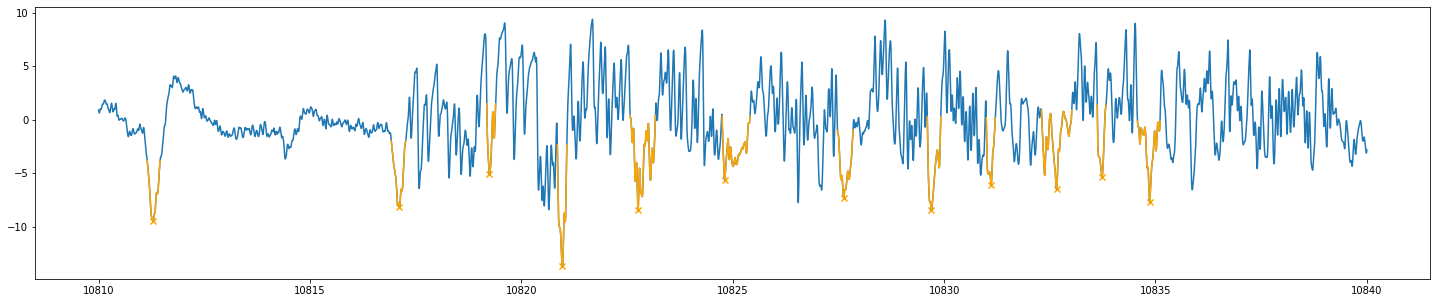

In [132]:
plt.figure(figsize=(25, 5))
[peaks, properties] = find_peaks(-v, height=5, width=rd.fs*0.2, prominence=8, distance=rd.fs*0.5)
plt.plot(t, v)
plt.scatter(t[peaks], v[peaks], c='orange', marker='x')
for i in range(len(peaks)):
  i_start = int(properties['left_ips'][i])
  i_stop = int(properties['right_ips'][i])
  plt.plot(t[i_start:i_stop], v[i_start:i_stop], color='orange')

In [97]:
properties

{'peak_heights': array([10.30356572,  8.82483425,  5.41025861, 13.64491711,  7.37123884,
         5.64385374,  7.52162256,  9.01252024,  5.8966263 ,  6.37985704,
         5.29580461,  7.30088199,  4.95694622]),
 'prominences': array([12.16607381, 13.16197094, 13.88049844, 23.31726319, 15.97864247,
        11.30569974, 16.61940486, 17.37350314, 11.6110337 , 13.68783944,
        13.47142517, 13.835345  , 10.74694662]),
 'left_bases': array([  4792,  57713, 292240, 306773, 373175, 456334, 373175, 373175,
        640307, 640307, 742708, 742708, 854414]),
 'right_bases': array([306773, 306773, 306773, 373175, 456334, 516691, 595114, 742708,
        688228, 742708, 784627, 854414, 922775]),
 'widths': array([10033.6310223 , 10781.52067683,  6578.97184553, 22305.66278056,
        19437.93868186, 34422.21228051, 24141.29957433, 10311.00853772,
        14076.16297062, 16548.45201737,  6436.63866706, 16154.15728427,
         8463.38388629]),
 'width_heights': array([ 4.22052882,  2.24384878, -1.

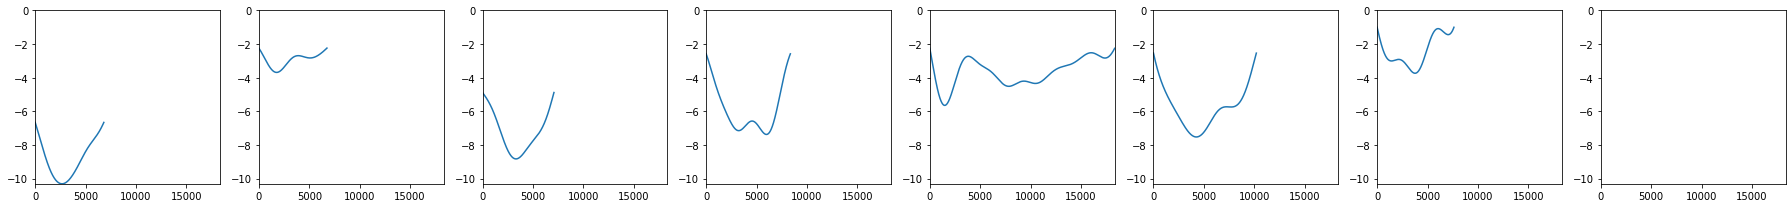

In [61]:
def plot_peaks(cols=8):
  rows = int(np.ceil(len(peaks)/cols))
  fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
  axes = axes.flatten()
  xmax, xmin, ymax, ymin = 0, 0, 0, 0
  for i, peak in enumerate(peaks):
      v_ = v[int(properties['left_ips'][i]):int(properties['right_ips'][i])]
      x_ = np.arange(0, len(v_))
      axes[i].plot(x_, v_)
      if min(v_) < ymin: ymin = min(v_)
      if min(x_) < xmin: xmin = min(x_)
      if max(v_) > ymax: ymax = max(v_)
      if max(x_) > xmax: xmax = max(x_)
  for ax in axes:
      ax.set_xlim([xmin, xmax])
      ax.set_ylim([ymin, ymax])
  fig.tight_layout()

plot_peaks()

In [18]:
for k, v in rd.reader.header.items():
  print(k, v)

nb_block 1
nb_segment [1]
signal_streams [('signals', '0')]
signal_channels [('CSC1', '19', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC10', '14', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC11', '2', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC12', '13', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC13', '3', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC14', '12', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC15', '5', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC16', '10', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC17', '6', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC18', '9', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC19', '7', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC2', '28', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC20', '8', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC21', '18', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC22', '29', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC23', '17', 3

In [69]:
rd.fs

32000.0

In [74]:
t = np.arange(rd.reader.segment_t_start(block_index=0, seg_index=0),
              rd.reader.segment_t_stop(block_index=0, seg_index=0), 1/rd.fs)
t.shape

(1786635777,)

In [80]:
x = np.array([1,2,3])
x[2:None]

array([3])

In [67]:
ev_timestamps, ev_durations, ev_labels = rd.reader.get_event_timestamps(block_index=0, seg_index=0, event_channel_index=0,
                                                                        t_start=None, t_stop=None)
ev_timestamps = rd.reader.rescale_event_timestamp(ev_timestamps, dtype='float64', event_channel_index=0)

In [68]:
ev_timestamps[-1]

55832.36300000176

In [64]:
raw_sigs = rd.reader.get_analogsignal_chunk(block_index=0, seg_index=0, i_start=0, i_stop=10000,
                                                      channel_names=[f'CSC32'])

In [65]:
raw_sigs

array([[-276],
       [-204],
       [-176],
       ...,
       [-363],
       [-405],
       [-391]], dtype=int16)